<img src="https://cdn.create.vista.com/api/media/medium/150929710/stock-photo-doctor-holding-x-ray?token=" width="620" height="360" align="center"/>

<br>
<h1 style = "font-size:30px; font-weight : bold; color : blue; text-align: center; border-radius: 10px 15px;">Pneumonia Detection with Transfer Learning: A Chest X-Ray Image Classification</h1>
<br>

---

#Overview
This notebook focuses on using Convolutional Neural Networks (CNNs) for classifying chest X-ray images to detect pneumonia. It employs three approaches:

**Simple CNN**: Building and training a basic CNN from scratch.

**Transfer Learning**: Using a pre-trained model with frozen layers for feature extraction.

**Fine Tuning**: Unfreezing and training the last layers of the pre-trained model for better adaptation to the pneumonia detection task.

The dataset used is the third version of the Chest X-Ray set, divided into training, validation, and test subsets. The project's goal is to develop an efficient model for accurate pneumonia detection, which is vital for early intervention and effective treatment. The research has significant implications for pediatric healthcare, potentially aiding in quicker diagnosis and treatment decisions, and contributes to the broader field of medical imaging and computer-aided diagnosis.


# <a id='0'>Content</a>

- <a href='#1'>Dataset Information</a>  
- <a href='#2'>Importing Packages and Dataset</a>  
- <a href='#3'>Exploring the Data</a>  
- <a href='#4'>Preprocessing the Data</a>
- <a href='#5'>Custom Model</a>
    - <a href='#5.1'>Model Definition</a>
    - <a href='#5.2'>Training the Model</a>
    - <a href='#5.3'>Model Prediction and Evaluation</a>
- <a href='#6'>Transfer Learning using ResNet</a>
    - <a href='#6.1'>Model Definition</a>
    - <a href='#6.2'>Training the Model</a>
    - <a href='#6.3'>Model Prediction and Evaluation</a>
- <a href='#7'>Fine Tuning using ResNet</a>
    - <a href='#7.1'>Model Definition</a>
    - <a href='#7.2'>Training the Model</a>
    - <a href='#7.3'>Model Prediction and Evaluation</a>
- <a href='#8'>Comparison of Results</a>
- <a href='#9'>Performance Metrics</a>
- <a href='#10'>References</a>

# <a href='#1'>Dataset Information</a>  

This dataset comprises 5,866 verified pediatric chest X-ray images, categorized as NORMAL, BACTERIA, or VIRUS, from Guangzhou Women and Children’s Medical Center. The images, filtered for quality and diagnosed by two expert physicians, are divided into training and testing sets for AI analysis. A third expert reviewed the evaluation set for grading accuracy.

Note: The Chest X-Ray dataset can be found at: [(link)](https://data.mendeley.com/datasets/rscbjbr9sj/3) and the third version can be downloaded from: [(link)](https://www.kaggle.com/tolgadincer/labeled-chest-xray-images)

# <a href='#2'>Importing Packages and Dataset</a>

In [ ]:
# Basic data handling and visualization libraries
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Setting display options for pandas
pd.options.display.max_colwidth = 100

# Libraries for setting seed for reproducibility
import random
import os
from numpy.random import seed
seed(42)  # Setting numpy seed
random.seed(42)  # Setting Python's random seed
os.environ['PYTHONHASHSEED'] = str(42)  # Environment variable for Python hash seed

# TensorFlow deterministic operations for reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Scikit-learn functions for model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

# TensorFlow and Keras for deep learning models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Glob for file path handling and cv2 for image processing
import glob
import cv2

# Setting TensorFlow random seed
from tensorflow.random import set_seed
set_seed(42)

# Suppress warnings for cleaner notebook presentation
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Image size for resizing the input images
IMG_SIZE = 224

# Batch size for model training and evaluation
BATCH = 32

# Seed for random operations to ensure reproducibility
SEED = 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Main path where the dataset is stored in the Colab notebook directory
main_path = "./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_xray"

# Paths for training and testing datasets
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

# Gathering file paths for normal and pneumonia images in the training set
train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

# Gathering file paths for normal and pneumonia images in the testing set
test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")


In [ ]:
# Creating a list of file paths for normal images in the training set
train_list = [x for x in train_normal]
# Extending the list with file paths for pneumonia images in the training set
train_list.extend([x for x in train_pneumonia])

# Creating a DataFrame for the training set with class labels
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal),
 ['Pneumonia']*len(train_pneumonia)]), columns=['class'])
# Adding image file paths to the training DataFrame
df_train['image'] = [x for x in train_list]

# Creating a list of file paths for normal images in the testing set
test_list = [x for x in test_normal]
# Extending the list with file paths for pneumonia images in the testing set
test_list.extend([x for x in test_pneumonia])

# Creating a DataFrame for the testing set with class labels
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal),
 ['Pneumonia']*len(test_pneumonia)]), columns=['class'])
# Adding image file paths to the testing DataFrame
df_test['image'] = [x for x in test_list]


In [ ]:
# Display the Train Dataframe
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5237  Pneumonia   
5238  Pneumonia   
5239  Pneumonia   
5240  Pneumonia   
5241  Pneumonia   

                                                                                                    image  
0     ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
1     ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2     ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
3     ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4     ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
...                                                                                                   ...  
5237  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
5238  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
5239  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
5240  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
5241  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  

[5242 rows x 2 columns]

In [ ]:
# Display the Test Dataframe
df_test

class  \
0       Normal   
1       Normal   
2       Normal   
3       Normal   
4       Normal   
..         ...   
619  Pneumonia   
620  Pneumonia   
621  Pneumonia   
622  Pneumonia   
623  Pneumonia   

                                                                                                   image  
0    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
1    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
3    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
..                                                                                                   ...  
619  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
620  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
621  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
622  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
623  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  

[624 rows x 2 columns]

# <a href='#3'>Exploring the Data</a>

Let's check the target distribution on each set

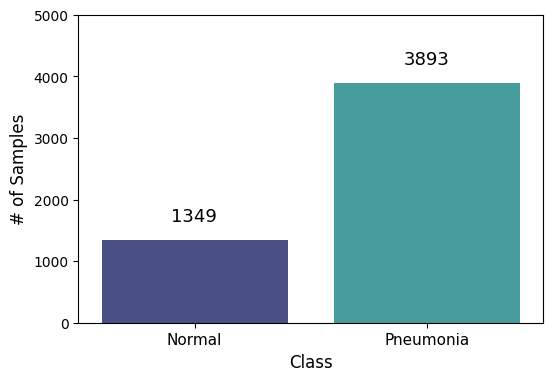

In [ ]:
# Setting up the figure size for the plot
plt.figure(figsize=(6,4))

# Creating a count plot for the 'class' column in the training dataset
ax = sns.countplot(x='class', data=df_train, palette="mako")

# Setting the label for the x-axis and its font size
plt.xlabel("Class", fontsize=12)
# Setting the label for the y-axis and its font size
plt.ylabel("# of Samples", fontsize=12)
# Setting the y-axis limit
plt.ylim(0,5000)
# Customizing the x-ticks with specific labels and font size
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize=11)

# Looping through each patch (bar in the bar plot)
for p in ax.patches:
    # Annotating the height of each bar (number of samples) above the bar
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.30, p.get_height() + 300), fontsize=13)

# Displaying the plot
plt.show()


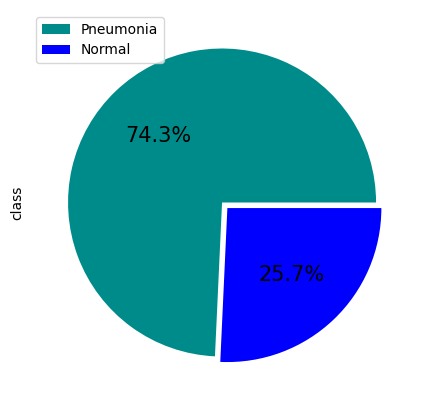

In [ ]:
# Setting up the figure size for the pie chart
plt.figure(figsize=(7,5))

# Creating a pie chart of class distribution in the training dataset
df_train['class'].value_counts().plot(
    kind='pie',  # Specifying the plot type as pie chart
    labels=['', ''],  # Removing the default labels
    autopct='%1.1f%%',  # Showing the percentage of each class
    colors=['darkcyan', 'blue'],  # Customizing colors for each class
    explode=[0, 0.05],  # Slightly separating the 'Normal' slice for emphasis
    textprops={"fontsize": 15}  # Setting the font size for the percentage labels
)

# Adding a legend to the plot
plt.legend(labels=['Pneumonia', 'Normal'])
# Displaying the plot
plt.show()


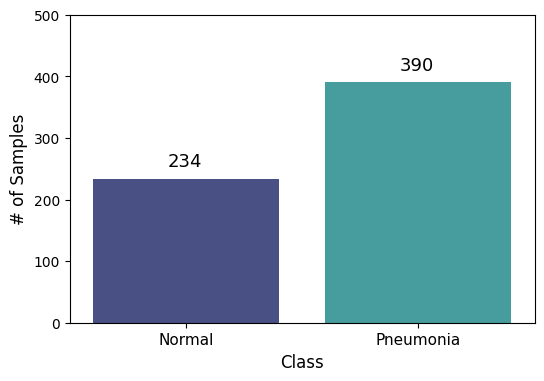

In [ ]:
# Setting up the figure size for the bar plot
plt.figure(figsize=(6,4))

# Creating a count plot for the 'class' column in the testing dataset
ax = sns.countplot(x='class', data=df_test, palette="mako")

# Setting the label for the x-axis and its font size
plt.xlabel("Class", fontsize=12)
# Setting the label for the y-axis and its font size
plt.ylabel("# of Samples", fontsize=12)
# Setting the y-axis limit
plt.ylim(0,500)
# Customizing the x-ticks with specific labels and font size
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize=11)

# Looping through each patch (bar in the bar plot)
for p in ax.patches:
    # Annotating the height of each bar (number of samples) above the bar
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.32, p.get_height() + 20), fontsize=13)

# Displaying the plot
plt.show()


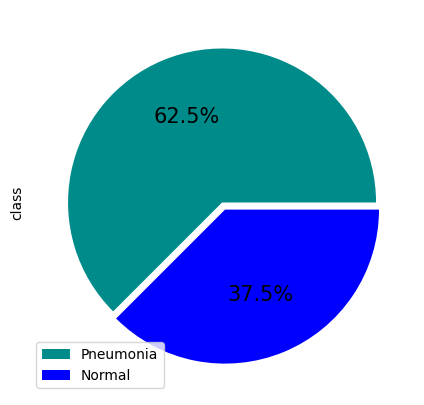

In [ ]:
# Setting up the figure size for the pie chart
plt.figure(figsize=(7,5))

# Creating a pie chart of class distribution in the testing dataset
df_test['class'].value_counts().plot(
    kind='pie',  # Specifying the plot type as pie chart
    labels=['', ''],  # Removing the default labels
    autopct='%1.1f%%',  # Showing the percentage of each class
    colors=['darkcyan', 'blue'],  # Customizing colors for each class
    explode=[0, 0.05],  # Slightly separating the 'Normal' slice for emphasis
    textprops={"fontsize": 15}  # Setting the font size for the percentage labels
)

# Adding a legend to the plot
plt.legend(labels=['Pneumonia', 'Normal'])
# Displaying the plot
plt.show()



The dataset distributions show a slight imbalance, with a higher prevalence of pneumonia cases, especially in the training set.<br>
Next, we'll examine some image examples from each dataset.

Train Set - Normal


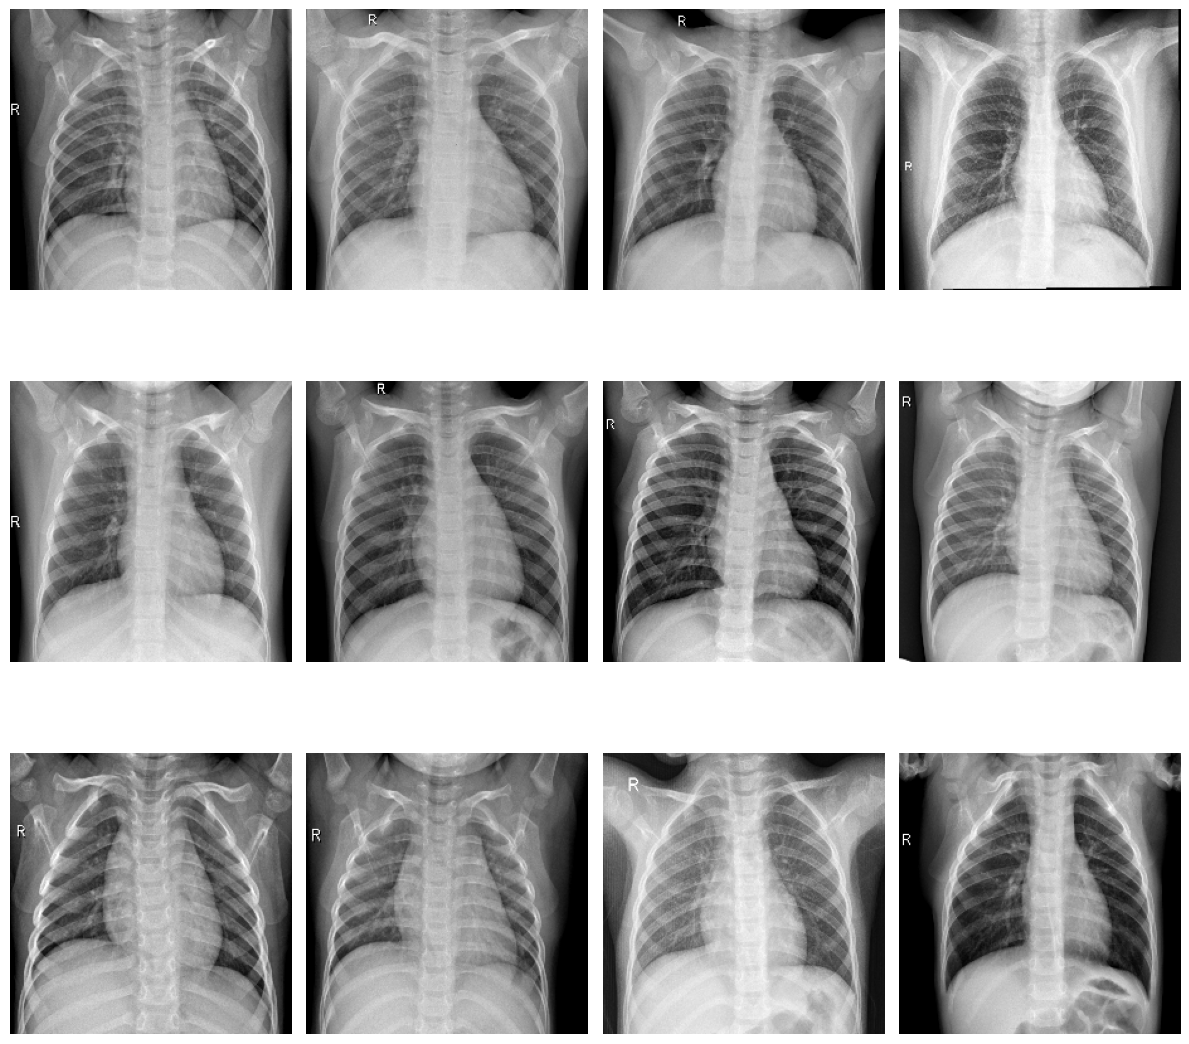

In [ ]:
# Displaying a selection of 'Normal' images from the training set
print('Train Set - Normal')

# Setting up the figure size for displaying multiple images
plt.figure(figsize=(12,12))

# Looping through the first 12 images in the 'Normal' training set
for i in range(0, 12):
    # Creating a subplot for each image
    plt.subplot(3, 4, i + 1)
    # Reading the image using cv2
    img = cv2.imread(train_normal[i])
    # Resizing the image to the specified IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Displaying the image
    plt.imshow(img)
    # Removing axis for a cleaner look
    plt.axis("off")

# Adjusting layout for better spacing
plt.tight_layout()

# Showing the plot with the images
plt.show()


Train Set - Pneumonia


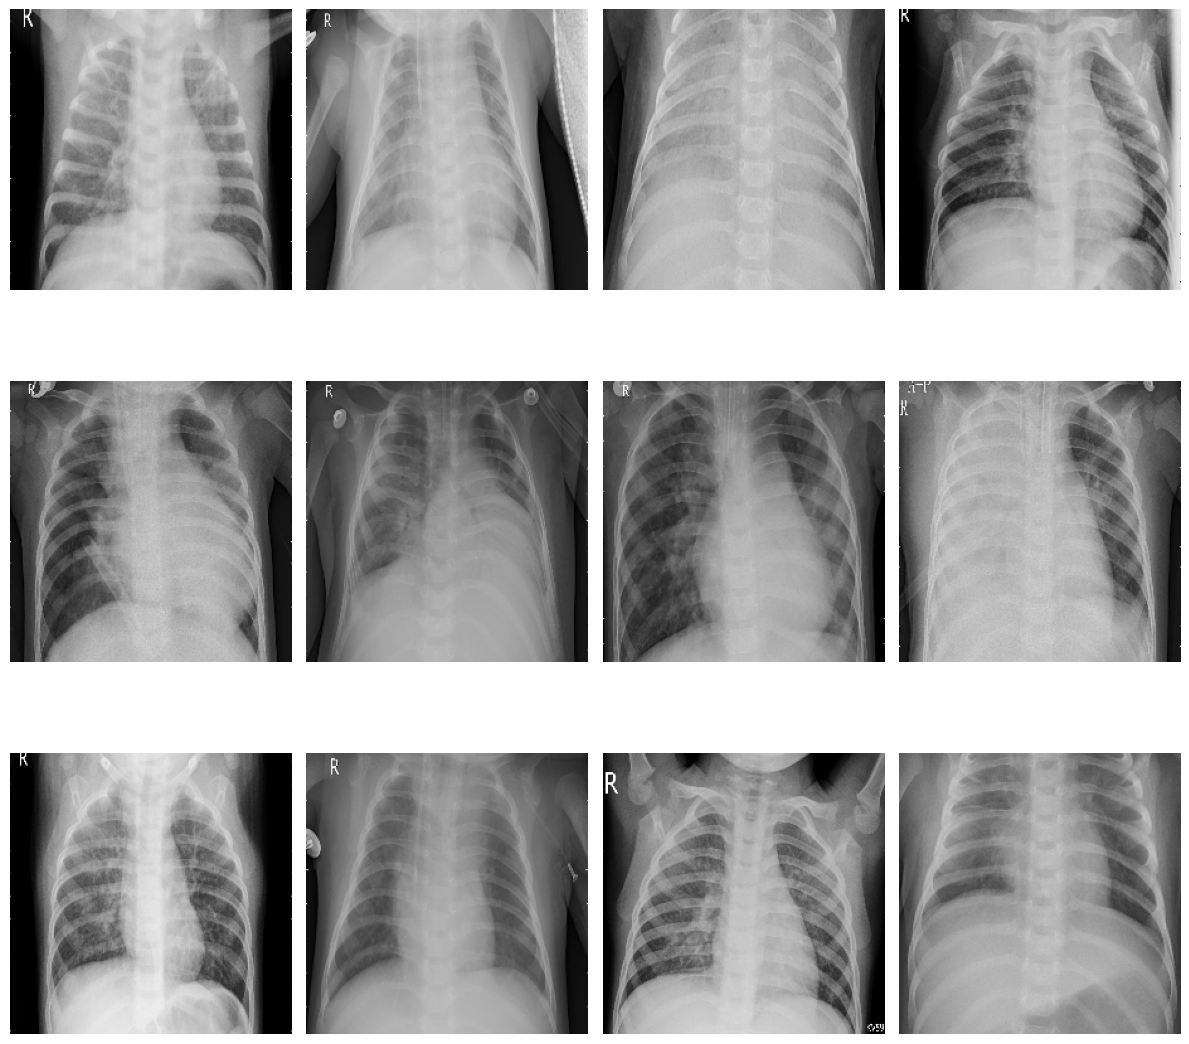

In [ ]:
# Displaying a selection of 'Pneumonia' images from the training set
print('Train Set - Pneumonia')

# Setting up the figure size for displaying multiple images
plt.figure(figsize=(12,12))

# Looping through the first 12 images in the 'Pneumonia' training set
for i in range(0, 12):
    # Creating a subplot for each image
    plt.subplot(3, 4, i + 1)
    # Reading the image using cv2
    img = cv2.imread(train_pneumonia[i])
    # Resizing the image to the specified IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Displaying the image
    plt.imshow(img)
    # Removing axis for a cleaner look
    plt.axis("off")

# Adjusting layout for better spacing
plt.tight_layout()

# Showing the plot with the images
plt.show()


Test Set - Normal


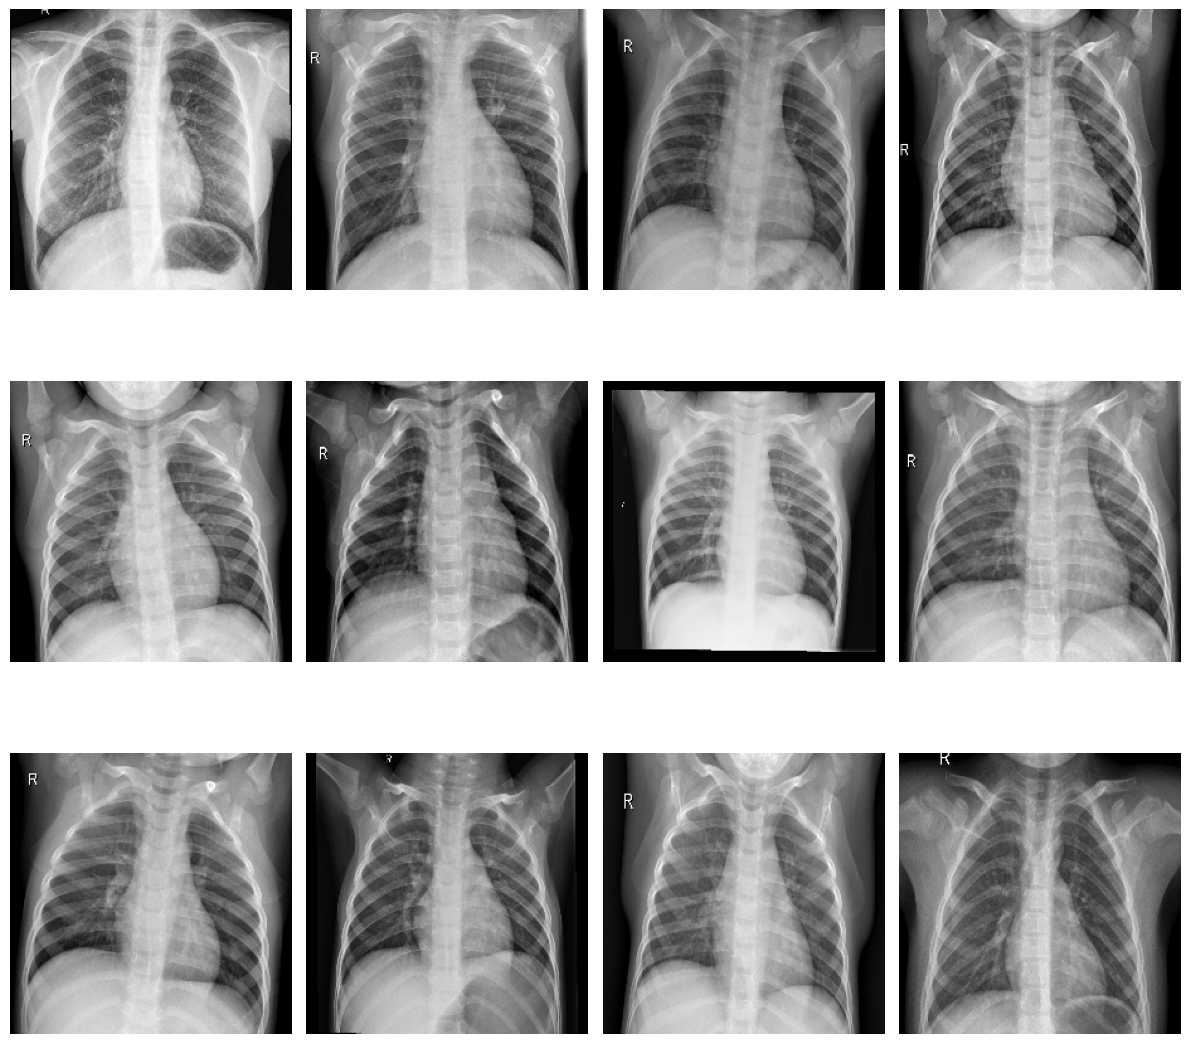

In [ ]:
# Displaying a selection of 'Normal' images from the test set
print('Test Set - Normal')

# Setting up the figure size for displaying multiple images
plt.figure(figsize=(12,12))

# Looping through the first 12 images in the 'Normal' test set
for i in range(0, 12):
    # Creating a subplot for each image
    plt.subplot(3, 4, i + 1)
    # Reading the image using cv2
    img = cv2.imread(test_normal[i])
    # Resizing the image to the specified IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Displaying the image
    plt.imshow(img)
    # Removing axis for a cleaner look
    plt.axis("off")

# Adjusting layout for better spacing
plt.tight_layout()

# Showing the plot with the images
plt.show()


Test Set - Pneumonia


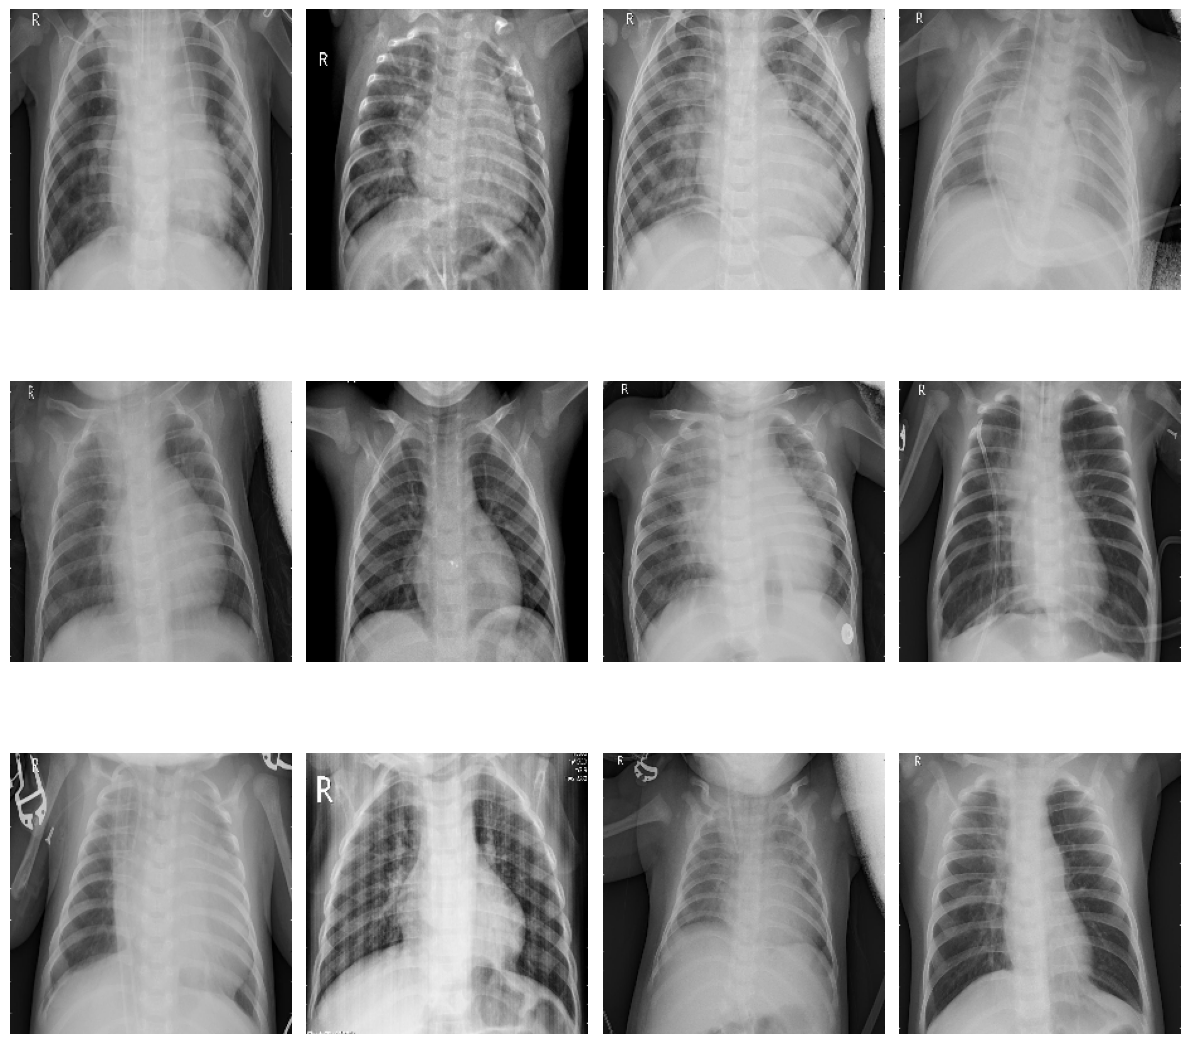

In [ ]:
# Displaying a selection of 'Pneumonia' images from the test set
print('Test Set - Pneumonia')

# Setting up the figure size for displaying multiple images
plt.figure(figsize=(12,12))

# Looping through the first 12 images in the 'Pneumonia' test set
for i in range(0, 12):
    # Creating a subplot for each image
    plt.subplot(3,4,i + 1)
    # Reading the image using cv2
    img = cv2.imread(test_pneumonia[i])
    # Resizing the image to the specified IMG_SIZE
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    # Displaying the image
    plt.imshow(img)
    # Removing axis for a cleaner look
    plt.axis("off")

# Adjusting layout for better spacing
plt.tight_layout()

# Showing the plot with the images
plt.show()

# <a href='#4'>Preprocessing the Data</a>

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [ ]:
# Splitting the original training dataset into training and validation sets
# The split is stratified to maintain the distribution of classes in both subsets
train_df, val_df = train_test_split(
    df_train,  # The original training dataframe
    test_size=0.20,  # Allocating 20% of the data for the validation set
    random_state=SEED,  # Using a seed for reproducibility
    stratify=df_train['class']  # Stratifying by the 'class' column to maintain class distribution
)


In [ ]:
# Display the Train Dataframe
train_df

class  \
1356  Pneumonia   
300      Normal   
705      Normal   
4189  Pneumonia   
4951  Pneumonia   
...         ...   
1740  Pneumonia   
5237  Pneumonia   
2370  Pneumonia   
678      Normal   
2192  Pneumonia   

                                                                                                    image  
1356  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
300   ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
705   ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4189  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4951  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
...                                                                                                   ...  
1740  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
5237  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2370  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
678   ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2192  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  

[4193 rows x 2 columns]

In [ ]:
# Display the Validation Dataframe
val_df

class  \
3862  Pneumonia   
709      Normal   
2342  Pneumonia   
1683  Pneumonia   
64       Normal   
...         ...   
1920  Pneumonia   
2879  Pneumonia   
2713  Pneumonia   
4937  Pneumonia   
4312  Pneumonia   

                                                                                                    image  
3862  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
709   ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2342  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
1683  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
64    ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
...                                                                                                   ...  
1920  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2879  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
2713  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4937  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  
4312  ./drive/MyDrive/Colab Notebooks/ML&NN/Transfer Learning Assignment/Transfer learning Code/chest_...  

[1049 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models.

We begin by defining the data generators. With Keras **Image Data Generator**, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the **flow_from_dataframe** method [link](//vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c). Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [ ]:
# Defining data generator for training set with data augmentation techniques
train_datagen = ImageDataGenerator(
    rescale=1/255.,  # Rescaling pixel values
    zoom_range=0.1,  # Applying random zoom for augmentation
    # rotation_range=0.1,  # Uncomment to apply rotation for augmentation
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1  # Random vertical shifts
)

# Defining data generator for validation and test sets (rescaling only)
val_datagen = ImageDataGenerator(rescale=1/255.)

# Preparing training dataset using the defined training data generator
ds_train = train_datagen.flow_from_dataframe(
    train_df,
    #directory=train_path, #dataframe contains the full paths
    x_col='image',  # Column in dataframe containing image paths
    y_col='class',  # Column in dataframe containing class labels
    target_size=(IMG_SIZE, IMG_SIZE),  # Resizing images
    class_mode='binary',  # Binary classification (Normal/Pneumonia)
    batch_size=BATCH,
    seed=SEED
)

# Preparing validation dataset using the validation data generator
ds_val = val_datagen.flow_from_dataframe(
    val_df,
    #directory=train_path,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED
)

# Preparing test dataset using the validation data generator
ds_test = val_datagen.flow_from_dataframe(
    df_test,
    #directory=test_path,
    x_col='image',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size=1,  # Processing one image at a time
    shuffle=False  # Keeping the order for evaluation purposes
)


Found 4193 validated image filenames belonging to 2 classes.
Found 1049 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


We're set to proceed with creating and training the image classification models.

#<a href='#5'>Custom Model</a>

In [ ]:
# Setting up an Early Stopping callback to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,  # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True,  # Restoring model weights from the epoch with the best value of the monitored quantity
)

# Setting up a Learning Rate Reduction on Plateau callback
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitoring validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_delt=1e-7,  # Minimum change in the monitored quantity to qualify as an improvement
    cooldown=0,  # Number of epochs to wait before resuming normal operation after lr has been reduced
    verbose=1  # Making it verbose to see the reduction in the logs
)


###<a href='#5.1'>Model Definition</a>

Let’s define our first model ‘from scratch’ and see how it performs.

In [ ]:
def get_model():
    # Define the input layer with shape [IMG_SIZE, IMG_SIZE, 3] for RGB images
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One: Convolutional layer, batch normalization, ReLU activation, max pooling and dropout
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two: Another set of convolutional layer, batch normalization, ReLU activation, max pooling and dropout
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three: Two convolutional layers, batch normalization, ReLU activation, max pooling and increased dropout
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head: Flatten the output and add a dense layer with dropout
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer: Dense layer with a sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    # Creating the model
    model = keras.Model(inputs=[inputs], outputs=output)

    return model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

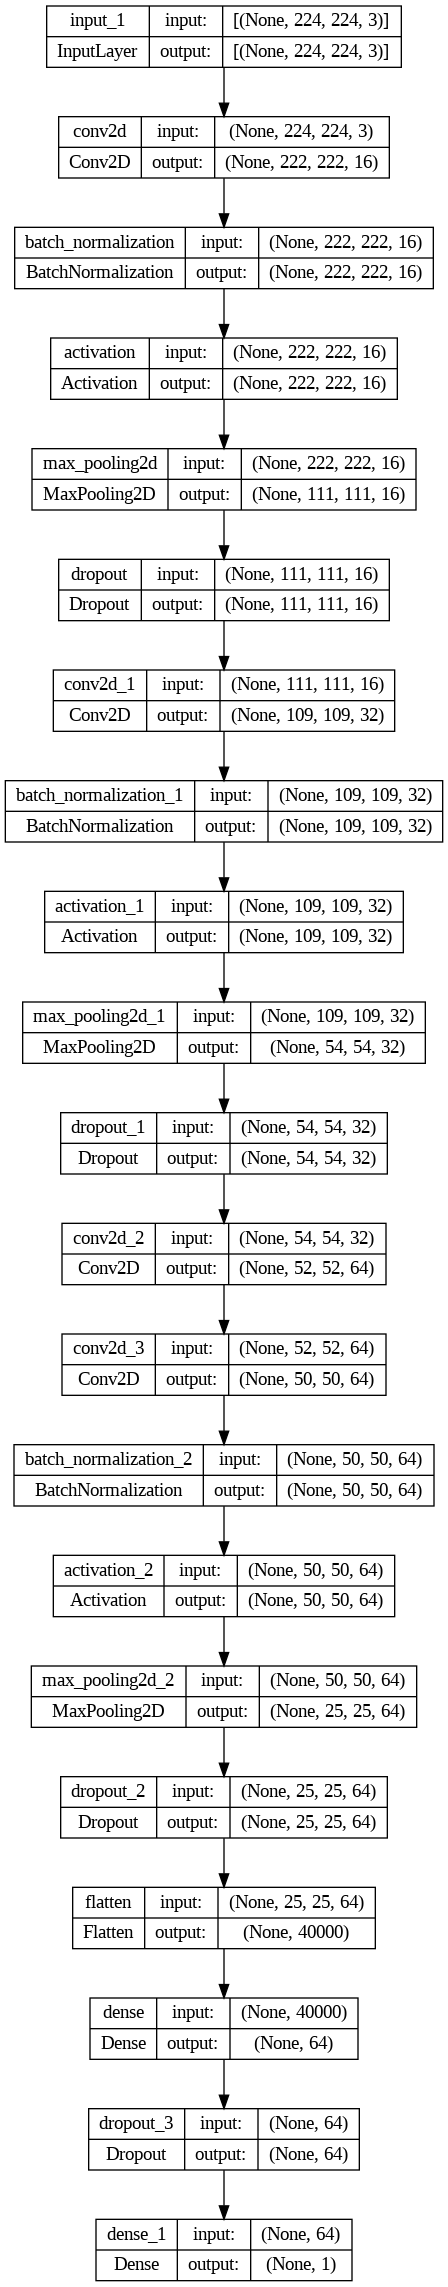

In [ ]:
# Clearing previous Keras backend session to reset layer names and avoid clutter from old models
keras.backend.clear_session()

# Creating a new model instance using the 'get_model' function
simplecnn_model = get_model()

# Compiling the model with binary crossentropy loss (suitable for binary classification),
# Adam optimizer with a learning rate of 3e-5, and tracking binary accuracy as a metric
simplecnn_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics='binary_accuracy'
)

# Printing the summary of the model to get an overview of its architecture, layer types, shapes and number of parameters
simplecnn_model.summary()

# Saving the model architecture as an image
plot_model(simplecnn_model, to_file='simplecnn_model_architecture.png', show_shapes=True)


###<a href='#5.2'>Training the Model</a>

Lets train the model using the training dataset, with specified callbacks for early stopping and learning rate adjustment.

In [ ]:
# Training the model using the training dataset
history_simplecnn = simplecnn_model.fit(
    ds_train,  # Training data generator
    batch_size=BATCH,  # Batch size for training
    epochs=50,  # Number of epochs to train for
    validation_data=ds_val,  # Validation data generator
    callbacks=[early_stopping, plateau],  # Applying early stopping and learning rate reduction on plateau
    steps_per_epoch=(len(train_df)/BATCH),  # Steps per epoch calculated as total training samples divided by batch size
    validation_steps=(len(val_df)/BATCH)  # Validation steps calculated as total validation samples divided by batch size
)


Epoch 1/50
131/131 [==============================] - 1191s 9s/step - loss: 0.4486 - binary_accuracy: 0.8025 - val_loss: 1.1781 - val_binary_accuracy: 0.7426 - lr: 3.0000e-05
Epoch 2/50
131/131 [==============================] - 122s 936ms/step - loss: 0.2837 - binary_accuracy: 0.8777 - val_loss: 1.8018 - val_binary_accuracy: 0.7426 - lr: 3.0000e-05
Epoch 3/50
132/131 [==============================] - ETA: 0s - loss: 0.2496 - binary_accuracy: 0.8970
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
131/131 [==============================] - 120s 916ms/step - loss: 0.2496 - binary_accuracy: 0.8970 - val_loss: 1.9679 - val_binary_accuracy: 0.7426 - lr: 3.0000e-05
Epoch 4/50
131/131 [==============================] - 122s 930ms/step - loss: 0.2219 - binary_accuracy: 0.9051 - val_loss: 1.3007 - val_binary_accuracy: 0.7426 - lr: 6.0000e-06
Epoch 5/50
131/131 [==============================] - 115s 876ms/step - loss: 0.1968 - binary_accuracy: 0.9177 - val_loss: 0.

###<a href='#5.3'>Model Prediction and Evaluation</a>

Now, let's proceed with model prediction and evaluation to assess its performance on unseen data.

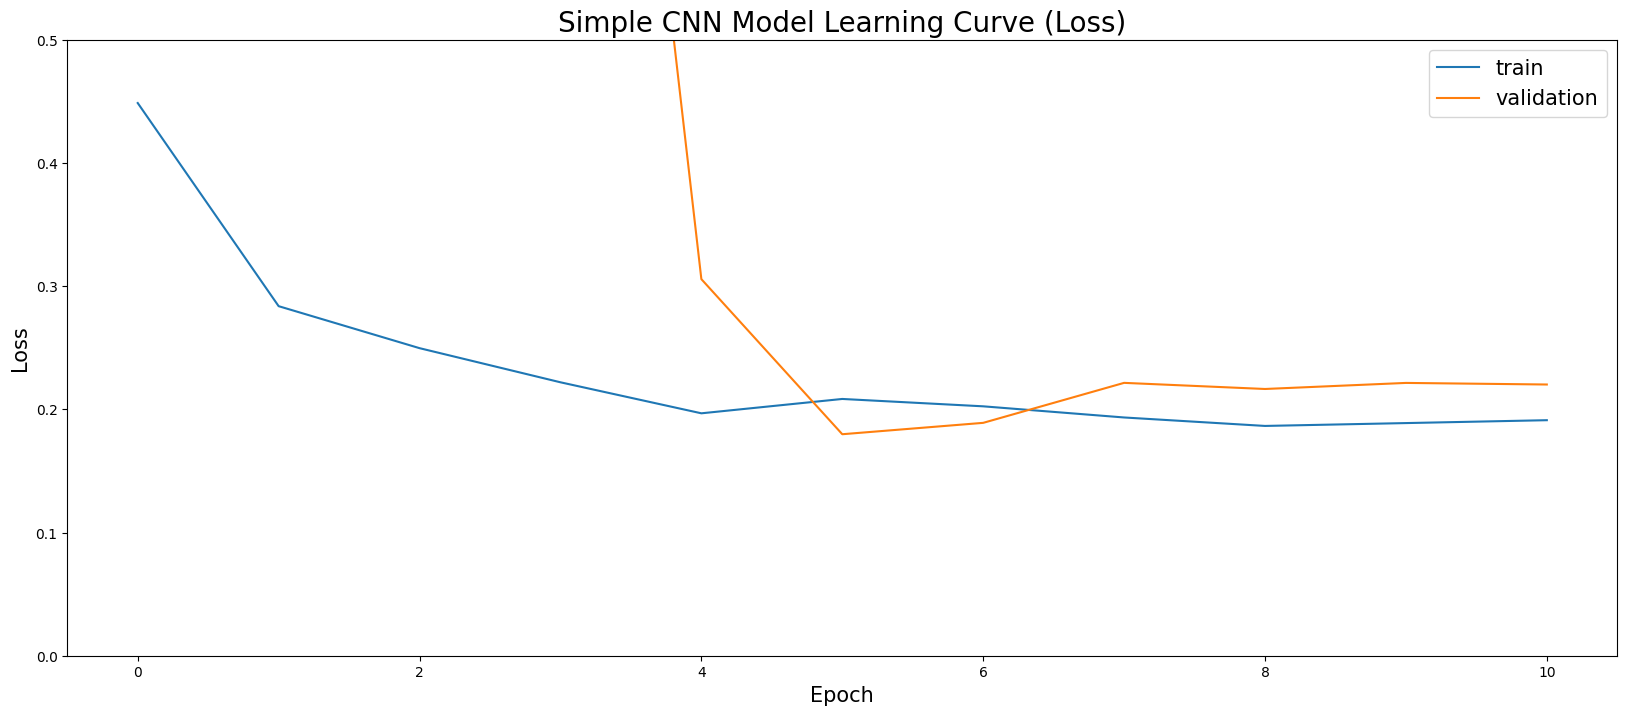

In [ ]:
# Creating a figure with specific size for the learning curve plot
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training loss
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['loss'], label='train')

# Plotting the validation loss
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['val_loss'], label='validation')

# Setting the title of the plot
ax.set_title('Simple CNN Model Learning Curve (Loss)', fontsize=20)

# Setting the label for the y-axis and its font size
ax.set_ylabel('Loss', fontsize=15)

# Setting the label for the x-axis and its font size
ax.set_xlabel('Epoch', fontsize=15)

# Setting the y-axis limits for a closer look at the relevant loss range
ax.set_ylim(0, 0.5)

# Adding a legend to differentiate between training and validation loss
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a publication-quality layout
plt.show()


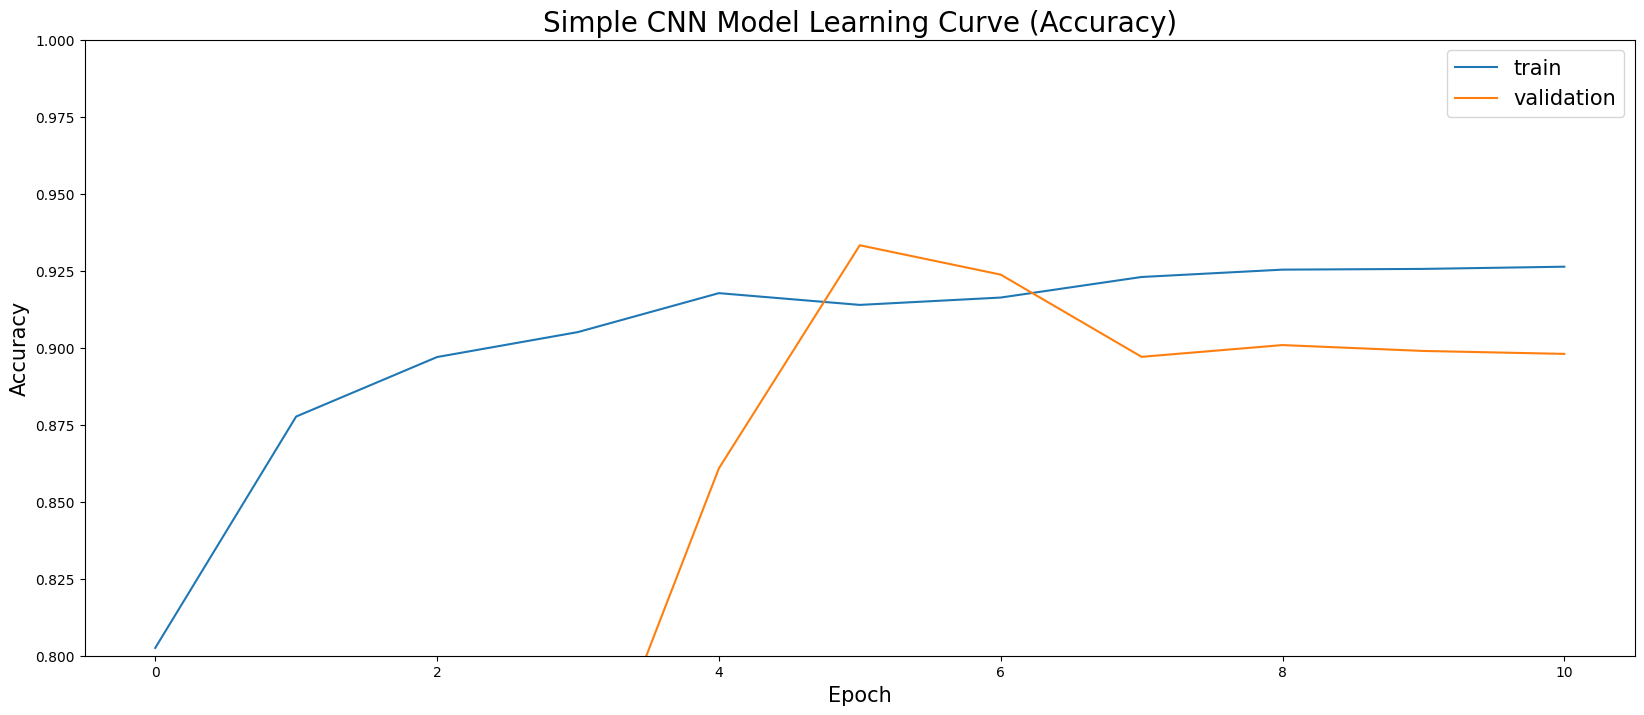

In [ ]:
# Creating a figure with specified dimensions for the accuracy learning curve
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training accuracy over epochs
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['binary_accuracy'], label='train')

# Plotting the validation accuracy over epochs
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['val_binary_accuracy'], label='validation')

# Setting the title of the plot with an appropriate font size
ax.set_title('Simple CNN Model Learning Curve (Accuracy)', fontsize=20)

# Setting the label and font size for the y-axis
ax.set_ylabel('Accuracy', fontsize=15)

# Setting the label and font size for the x-axis
ax.set_xlabel('Epoch', fontsize=15)

# Adjusting the y-axis limit to focus on the relevant accuracy range
ax.set_ylim(0.80, 1.0)

# Adding a legend to distinguish between training and validation accuracy
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a layout suitable for publication
plt.show()


In [ ]:
# Evaluating the model on the validation dataset
score_simplecnn = simplecnn_model.evaluate(
    ds_val,  # Validation data generator
    steps=len(val_df)/BATCH,  # Number of steps in the evaluation process
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the validation dataset
print('Val loss:', score_simplecnn[0])  # Validation loss
print('Val accuracy:', score_simplecnn[1])  # Validation accuracy


Val loss: 0.17978383600711823
Val accuracy: 0.9332697987556458


In [ ]:
# Evaluating the model on the test dataset
score_simplecnn = simplecnn_model.evaluate(
    ds_test,  # Test data generator
    steps=len(df_test),  # Number of steps in the evaluation process equals the number of samples in the test set
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the test dataset
print('Test loss:', score_simplecnn[0])  # Test loss
print('Test accuracy:', score_simplecnn[1])  # Test accuracy


Test loss: 0.3550311028957367
Test accuracy: 0.8541666865348816


#<a href='#6'>Transfer Learning using ResNet</a>

Transfer learning in this project involves leveraging the pre-trained ResNet152V2 model from Keras [(link)](https://keras.io/api/applications/resnet/#resnet152v2-function), initially trained on ImageNet. By setting include_top to false, we exclude the original classification layer (head) and retain the base layers for feature extraction. We then append our custom layers, culminating in an output layer tailored for our specific classification task. This approach adapts the model, originally trained on a diverse image set, to our specialized task of classifying chest X-ray images.

###<a href='#6.1'>Model Definition</a>

Let's define a model that incorporates the pre-trained ResNet152V2 as a feature extractor, with custom layers added for the specific task of classifying chest X-ray images.

In [ ]:
# Initializing the ResNet152V2 model with pre-trained ImageNet weights
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',  # Loading weights pre-trained on ImageNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Specifying the input shape of our images
    include_top=False  # Excluding the top (output) layer of the network
)

# Setting the base model layers to non-trainable (freezing them)
base_model.trainable = False

def get_pretrained():
    # Defining the input layer with the specified shape [IMG_SIZE, IMG_SIZE, 3]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Passing the inputs through the base model
    x = base_model(inputs)

    # Head: Adding global average pooling followed by a dense layer with dropout
    x = layers.GlobalAveragePooling2D()(x)  # Reduces each feature map to a single value, helping to reduce model complexity
    x = layers.Dense(128, activation='relu')(x)  # Dense layer with 128 units and ReLU activation
    x = layers.Dropout(0.1)(x)  # Dropout to reduce overfitting

    # Output layer: Dense layer with a single unit and sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    # Constructing the final model with the specified inputs and outputs
    model = keras.Model(inputs=[inputs], outputs=output)

    return model


234545216/234545216 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

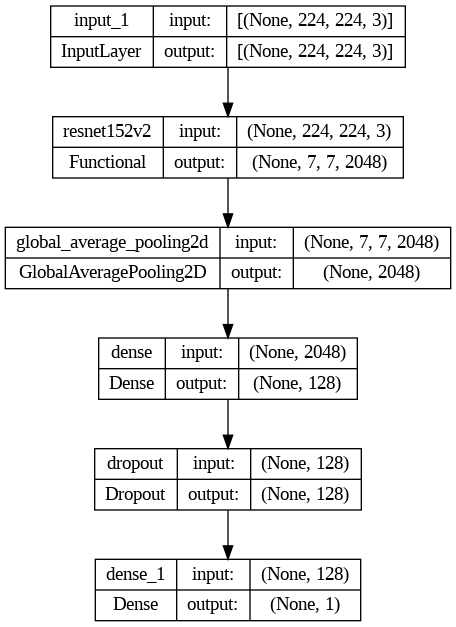

In [ ]:
# Clearing previous Keras backend session to reset layer names and avoid clutter from old models
keras.backend.clear_session()

# Creating a new model instance using the 'get_pretrained' function, which includes the pre-trained ResNet152V2
model_pretrained = get_pretrained()

# Compiling the pre-trained model with binary crossentropy loss and Adam optimizer
# This setup is specifically for binary classification tasks
model_pretrained.compile(
    loss='binary_crossentropy',  # Using binary crossentropy as the loss function for binary classification
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Adam optimizer with a learning rate of 5e-5
    metrics='binary_accuracy'  # Tracking binary accuracy as a metric
)

# Printing the summary of the pre-trained model to get an overview of its architecture, layer types, shapes and number of parameters
model_pretrained.summary()

# Saving the model architecture as an image
plot_model(model_pretrained, to_file='model_pretrained_architecture.png', show_shapes=True)

###<a href='#6.2'>Training the Model</a>

Let's train the pre-trained model using the training dataset, applying callbacks for early stopping and learning rate adjustment based on validation loss.

In [ ]:
# Training the pre-trained model using the training dataset
history_pretrained = model_pretrained.fit(
    ds_train,  # Training data generator
    batch_size=BATCH,  # Batch size for training
    epochs=50,  # Number of epochs to train for
    validation_data=ds_val,  # Validation data generator
    callbacks=[early_stopping, plateau],  # Applying early stopping and learning rate reduction on plateau
    steps_per_epoch=(len(train_df)/BATCH),  # Steps per epoch calculated as total training samples divided by batch size
    validation_steps=(len(val_df)/BATCH)  # Validation steps calculated as total validation samples divided by batch size
)


Epoch 1/50
131/131 [==============================] - 147s 1s/step - loss: 0.4114 - binary_accuracy: 0.8133 - val_loss: 0.2334 - val_binary_accuracy: 0.9123 - lr: 5.0000e-05
Epoch 2/50
131/131 [==============================] - 138s 1s/step - loss: 0.1942 - binary_accuracy: 0.9251 - val_loss: 0.1821 - val_binary_accuracy: 0.9266 - lr: 5.0000e-05
Epoch 3/50
131/131 [==============================] - 137s 1s/step - loss: 0.1607 - binary_accuracy: 0.9418 - val_loss: 0.1612 - val_binary_accuracy: 0.9399 - lr: 5.0000e-05
Epoch 4/50
131/131 [==============================] - 133s 1s/step - loss: 0.1479 - binary_accuracy: 0.9440 - val_loss: 0.1467 - val_binary_accuracy: 0.9457 - lr: 5.0000e-05
Epoch 5/50
131/131 [==============================] - 138s 1s/step - loss: 0.1394 - binary_accuracy: 0.9478 - val_loss: 0.1402 - val_binary_accuracy: 0.9504 - lr: 5.0000e-05
Epoch 6/50
131/131 [==============================] - 134s 1s/step - loss: 0.1235 - binary_accuracy: 0.9523 - val_loss: 0.1297 - v

###<a href='#6.3'>Model Prediction and Evaluation</a>

Now, let's proceed with pre-trained model prediction and evaluation to assess its performance on unseen data.

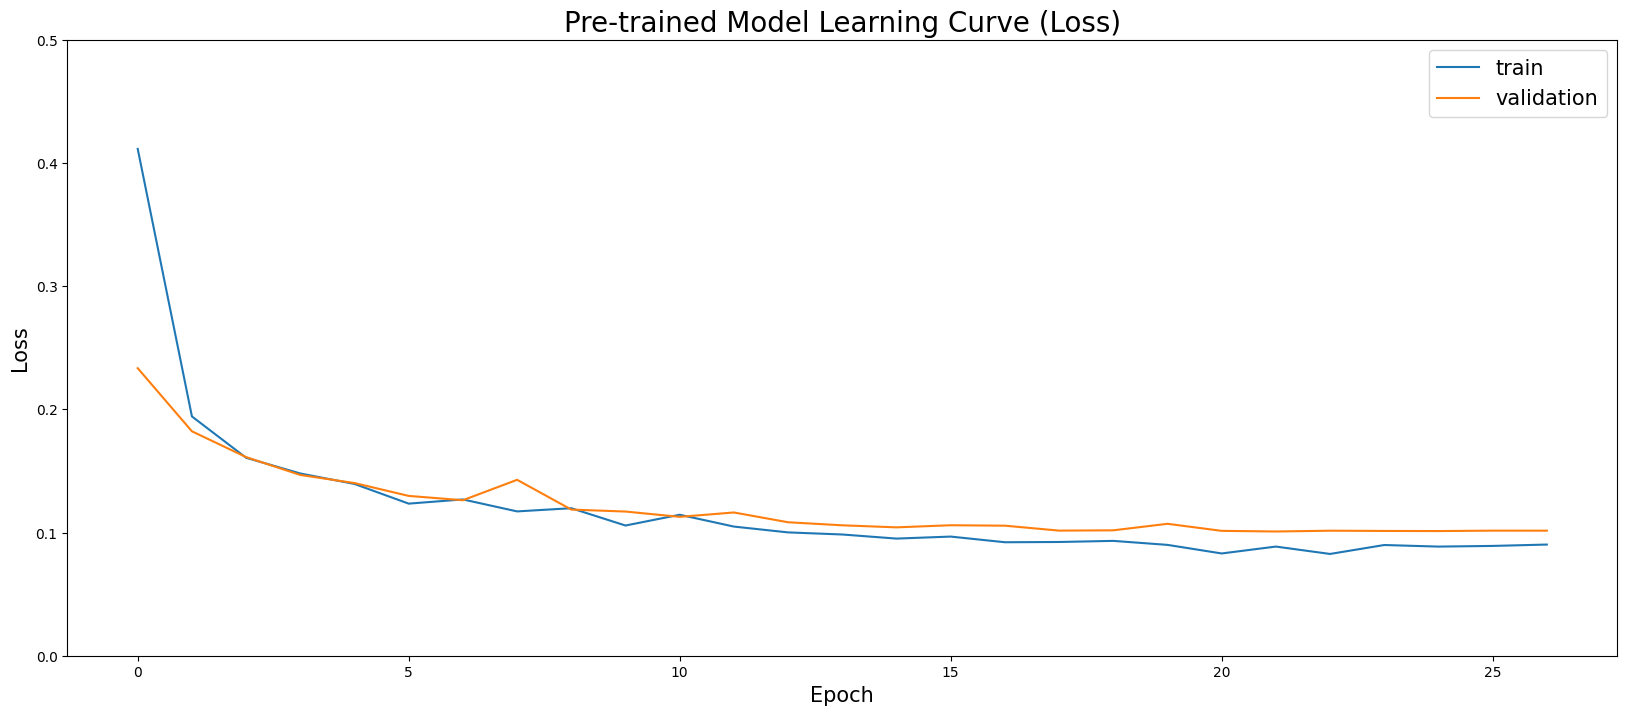

In [ ]:
# Creating a figure with specified dimensions for the learning curve plot (loss)
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training loss across epochs
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['loss'], label='train')

# Plotting the validation loss across epochs
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['val_loss'], label='validation')

# Setting the title of the plot with an appropriate font size
ax.set_title('Pre-trained Model Learning Curve (Loss)', fontsize=20)

# Setting the label and font size for the y-axis
ax.set_ylabel('Loss', fontsize=15)

# Setting the label and font size for the x-axis
ax.set_xlabel('Epoch', fontsize=15)

# Adjusting the y-axis limit to focus on the relevant loss range
ax.set_ylim(0, 0.5)

# Adding a legend to differentiate between training and validation loss
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a layout suitable for publication
plt.show()


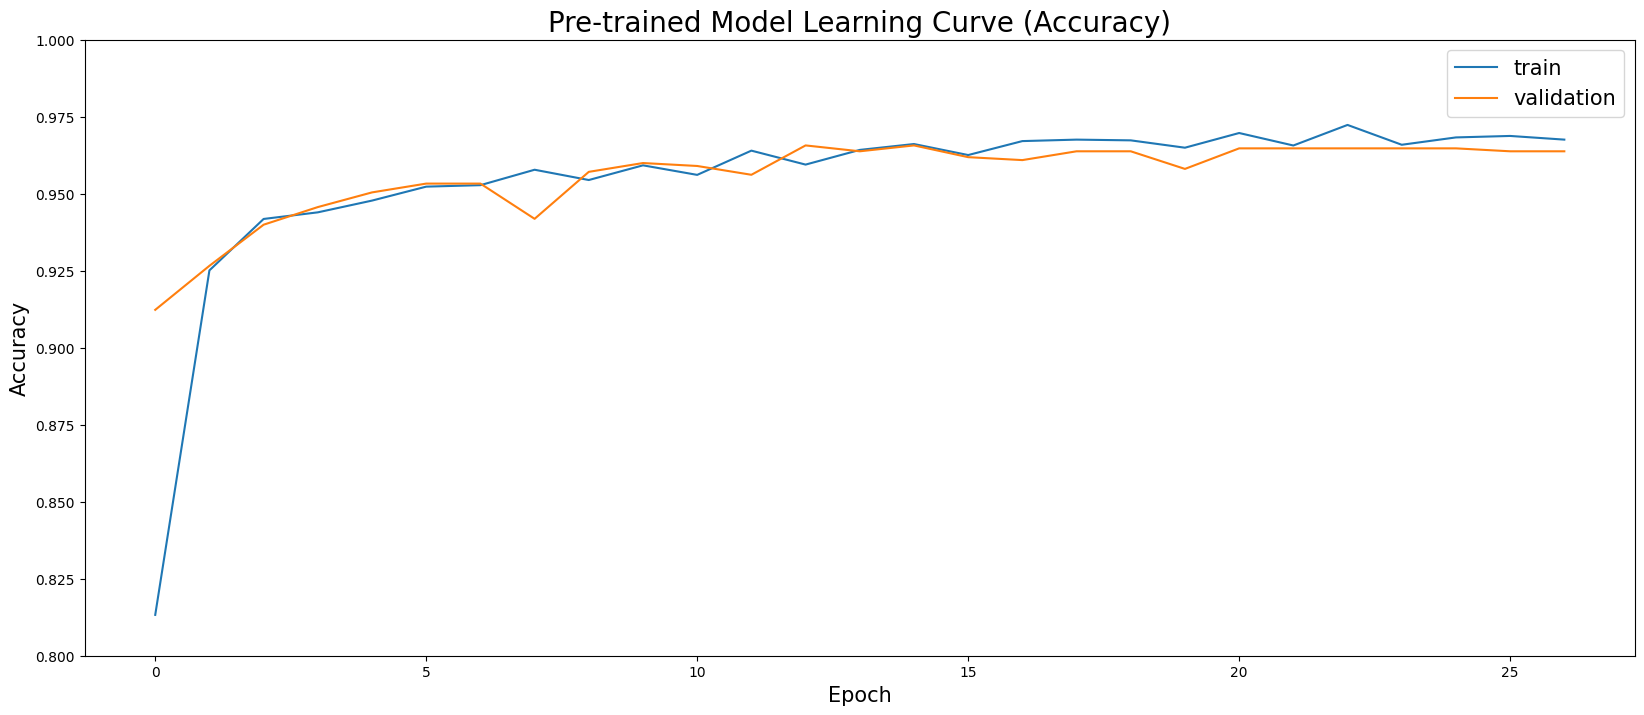

In [ ]:
# Creating a figure with specified dimensions for the accuracy learning curve
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training accuracy across epochs using seaborn's lineplot
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['binary_accuracy'], label='train')

# Plotting the validation accuracy across epochs
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['val_binary_accuracy'], label='validation')

# Setting the title of the plot with an appropriate font size for clarity and readability
ax.set_title('Pre-trained Model Learning Curve (Accuracy)', fontsize=20)

# Labeling the y-axis as 'Accuracy' and setting its font size
ax.set_ylabel('Accuracy', fontsize=15)

# Labeling the x-axis as 'Epoch' and setting its font size
ax.set_xlabel('Epoch', fontsize=15)

# Adjusting the y-axis limit to focus on the higher accuracy range, making the plot more informative
ax.set_ylim(0.80, 1.0)

# Adding a legend to distinguish between training and validation accuracy, placed in the best location for readability
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a layout suitable for publication, ensuring high-quality visualization
plt.show()


In [ ]:
# Evaluating the performance of the pre-trained model on the validation dataset
score_pretrained = model_pretrained.evaluate(
    ds_val,  # Validation data generator
    steps=len(val_df)/BATCH,  # Number of steps in the evaluation process
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the validation dataset
print('Val loss:', score_pretrained[0])  # Displaying the validation loss
print('Val accuracy:', score_pretrained[1])  # Displaying the validation accuracy


Val loss: 0.10083475708961487
Val accuracy: 0.9647282958030701


In [ ]:
# Evaluating the performance of the pre-trained model on the test dataset
score_pretrained = model_pretrained.evaluate(
    ds_test,  # Test data generator
    steps=len(df_test),  # Number of steps in the evaluation process equals the number of samples in the test set
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the test dataset
print('Test loss:', score_pretrained[0])  # Displaying the test loss
print('Test accuracy:', score_pretrained[1])  # Displaying the test accuracy


Test loss: 0.26863861083984375
Test accuracy: 0.9006410241127014


#<a href='#7'>Fine Tuning using ResNet</a>

The Fine Tuning approach involves partially modifying a pre-trained model. Previously, we kept all layers of the pre-trained model frozen, maintaining the weights from its original ImageNet training. Now, we'll unfreeze some of the model's final layers, allowing their weights to be adjusted during further training. This process aims to fine-tune the model's higher-level features to better suit our specific dataset.

###<a href='#7.1'>Model Definition</a>

Let's set up the base model for fine-tuning by allowing the last 13 layers to be trainable. The rest of the layers remain frozen, preserving the learned features from the original ImageNet training. A low learning rate is chosen to make smaller, more precise updates during training.

In [ ]:
# Enabling training for the base model (previously frozen)
base_model.trainable = True

# Freezing all layers in the base model except for the last 13
# This allows only the last 13 layers of the model to be trainable
for layer in base_model.layers[:-13]:
    layer.trainable = False


In [ ]:
# Iterating over the layers of the base model to check their trainable status
for layer_number, layer in enumerate(base_model.layers):
    # Printing the layer number, name, and whether it is trainable
    print(layer_number, layer.name, layer.trainable)


0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

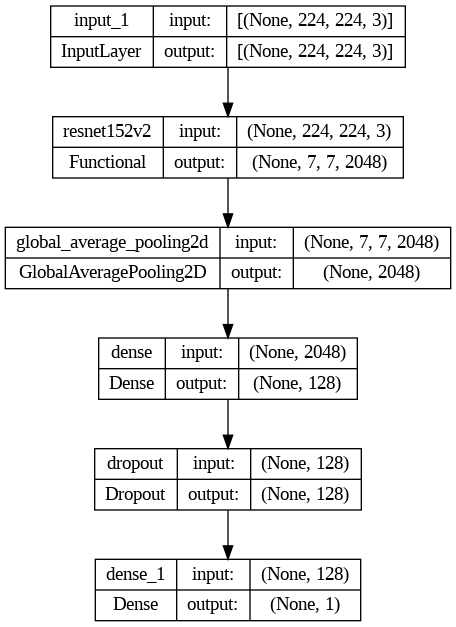

In [ ]:
# Re-compiling the pre-trained model after unfreezing some layers
model_pretrained.compile(
    loss='binary_crossentropy',  # Using binary crossentropy as the loss function for binary classification
    optimizer=keras.optimizers.Adam(learning_rate=2e-6),  # Adam optimizer with a very low learning rate for fine-tuning
    metrics='binary_accuracy'  # Tracking binary accuracy as a metric
)

# Printing the summary of the model to view the updated architecture and layer trainability
model_pretrained.summary()

# Saving the model architecture as an image
plot_model(model_pretrained, to_file='model_finetuned_architecture.png', show_shapes=True)

###<a href='#7.2'>Training the Model</a>

Let's fine-tune the pre-trained model with the last few layers unfrozen, using the training dataset and applying callbacks for early stopping and learning rate adjustment. The fine-tuning aims to optimize the model's performance on the dataset.

In [ ]:
# Continuing the training process of the pre-trained model with fine-tuning
history_finetuned = model_pretrained.fit(
    ds_train,  # Training data generator
    batch_size=BATCH,  # Batch size for training
    epochs=50,  # Number of epochs to train for
    validation_data=ds_val,  # Validation data generator
    callbacks=[early_stopping, plateau],  # Applying early stopping and learning rate reduction on plateau
    steps_per_epoch=(len(train_df)/BATCH),  # Calculating steps per epoch based on training data size and batch size
    validation_steps=(len(val_df)/BATCH)  # Calculating validation steps based on validation data size and batch size
)


Epoch 1/50
131/131 [==============================] - 151s 1s/step - loss: 0.1614 - binary_accuracy: 0.9370 - val_loss: 0.1613 - val_binary_accuracy: 0.9342 - lr: 2.0000e-06
Epoch 2/50
131/131 [==============================] - 135s 1s/step - loss: 0.1434 - binary_accuracy: 0.9528 - val_loss: 0.1466 - val_binary_accuracy: 0.9428 - lr: 2.0000e-06
Epoch 3/50
131/131 [==============================] - 138s 1s/step - loss: 0.1234 - binary_accuracy: 0.9599 - val_loss: 0.1345 - val_binary_accuracy: 0.9495 - lr: 2.0000e-06
Epoch 4/50
131/131 [==============================] - 138s 1s/step - loss: 0.1249 - binary_accuracy: 0.9580 - val_loss: 0.1330 - val_binary_accuracy: 0.9495 - lr: 2.0000e-06
Epoch 5/50
131/131 [==============================] - 137s 1s/step - loss: 0.1209 - binary_accuracy: 0.9554 - val_loss: 0.1271 - val_binary_accuracy: 0.9542 - lr: 2.0000e-06
Epoch 6/50
131/131 [==============================] - 135s 1s/step - loss: 0.1212 - binary_accuracy: 0.9590 - val_loss: 0.1236 - v

###<a href='#7.3'>Model Prediction and Evaluation</a>

Now proceed with predicting and evaluating the model's performance using the test dataset to assess its effectiveness after fine-tuning.

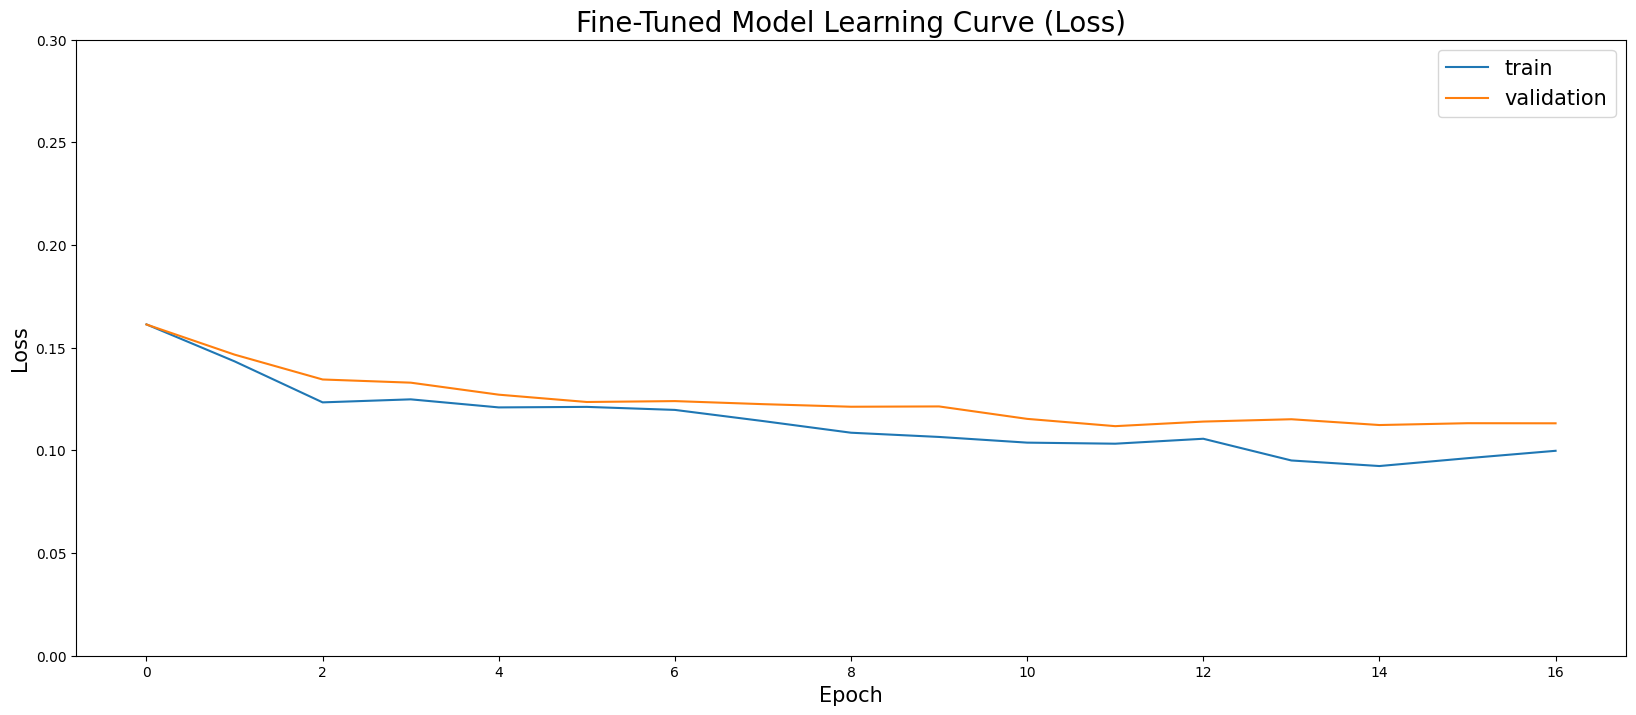

In [ ]:
# Creating a figure with specified dimensions for the learning curve plot (loss)
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training loss over epochs using seaborn's lineplot
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['loss'], label='train')

# Plotting the validation loss over epochs
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['val_loss'], label='validation')

# Setting the title of the plot with an appropriate font size for readability
ax.set_title('Fine-Tuned Model Learning Curve (Loss)', fontsize=20)

# Labeling the y-axis as 'Loss' and setting its font size
ax.set_ylabel('Loss', fontsize=15)

# Labeling the x-axis as 'Epoch' and setting its font size
ax.set_xlabel('Epoch', fontsize=15)

# Adjusting the y-axis limit to focus on the lower loss range for more detail
ax.set_ylim(0, 0.3)

# Adding a legend to differentiate between training and validation loss, positioned optimally for clarity
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a high-quality layout suitable for publication
plt.show()


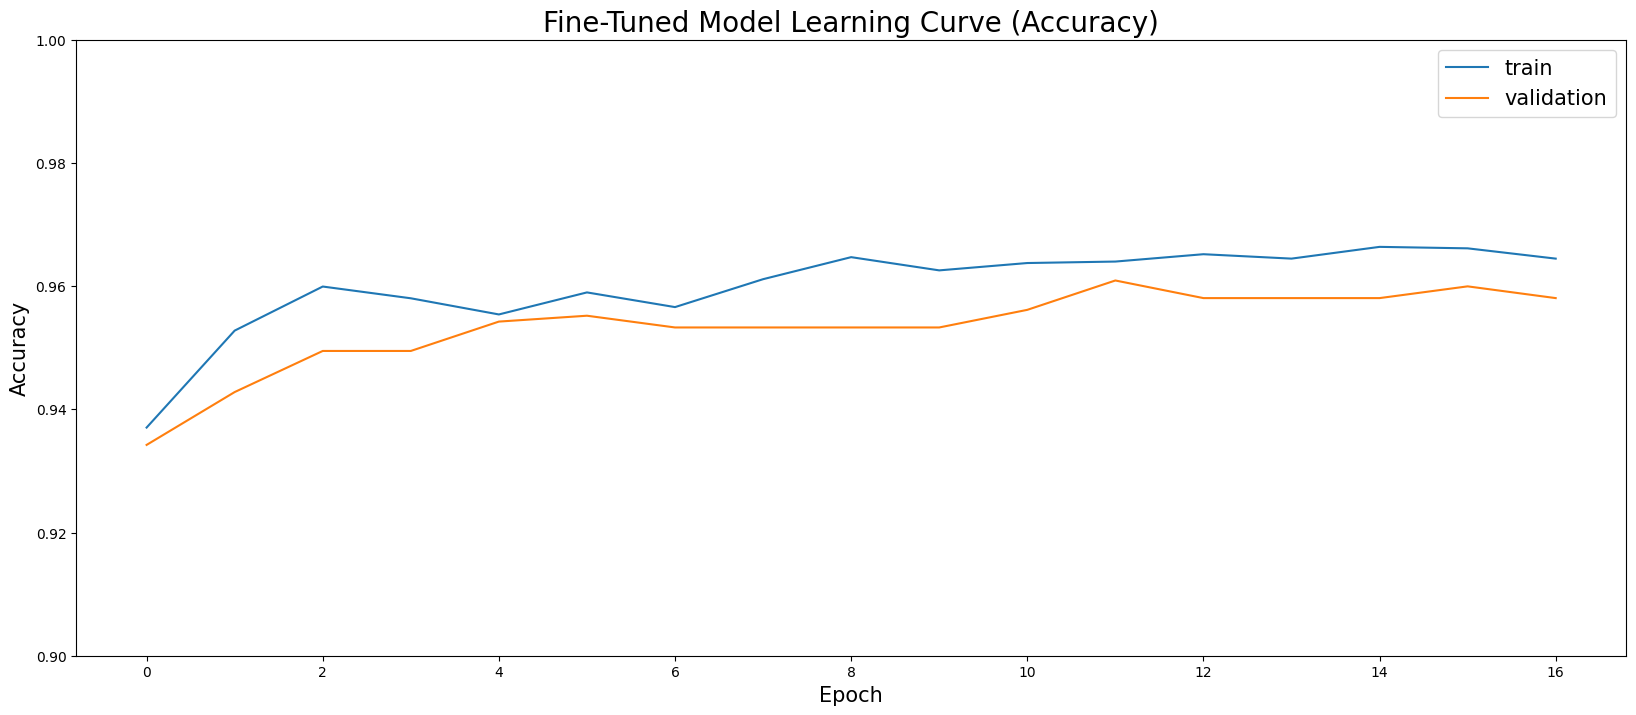

In [ ]:
# Creating a figure with specified dimensions for the accuracy learning curve
fig, ax = plt.subplots(figsize=(20,8))

# Plotting the training accuracy over epochs using seaborn's lineplot
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['binary_accuracy'], label='train')

# Plotting the validation accuracy over epochs
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['val_binary_accuracy'], label='validation')

# Setting the title of the plot with an appropriate font size for clarity and readability
ax.set_title('Fine-Tuned Model Learning Curve (Accuracy)', fontsize=20)

# Labeling the y-axis as 'Accuracy' and setting its font size
ax.set_ylabel('Accuracy', fontsize=15)

# Labeling the x-axis as 'Epoch' and setting its font size
ax.set_xlabel('Epoch', fontsize=15)

# Adjusting the y-axis limit to focus on the higher accuracy range, making the plot more informative
ax.set_ylim(0.90, 1.0)

# Adding a legend to distinguish between training and validation accuracy, placed in the best location for readability
ax.legend(loc='best', fontsize=15)

# Displaying the plot with a layout suitable for publication, ensuring high-quality visualization
plt.show()


In [ ]:
# Evaluating the performance of the fine-tuned model on the validation dataset
score_finetuned = model_pretrained.evaluate(
    ds_val,  # Validation data generator
    steps=len(val_df)/BATCH,  # Number of steps in the evaluation process
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the validation dataset
print('Val loss:', score_finetuned[0])  # Displaying the validation loss
print('Val accuracy:', score_finetuned[1])  # Displaying the validation accuracy


Val loss: 0.11180379986763
Val accuracy: 0.9609151482582092


In [ ]:
# Evaluating the performance of the fine-tuned model on the test dataset
score_finetuned = model_pretrained.evaluate(
    ds_test,  # Test data generator
    steps=len(df_test),  # Number of steps in the evaluation process equals the total number of test samples
    verbose=0  # Silent mode (no output during the evaluation)
)

# Printing the loss and accuracy on the test dataset
print('Test loss:', score_finetuned[0])  # Displaying the test loss
print('Test accuracy:', score_finetuned[1])  # Displaying the test accuracy


Test loss: 0.23514769971370697
Test accuracy: 0.9054487347602844


#<a href='#8'>Comparison of Results</a>

To compare the results of the three models - the custom model, the model using transfer learning, and the fine-tuned model - creating a set of visualizations.

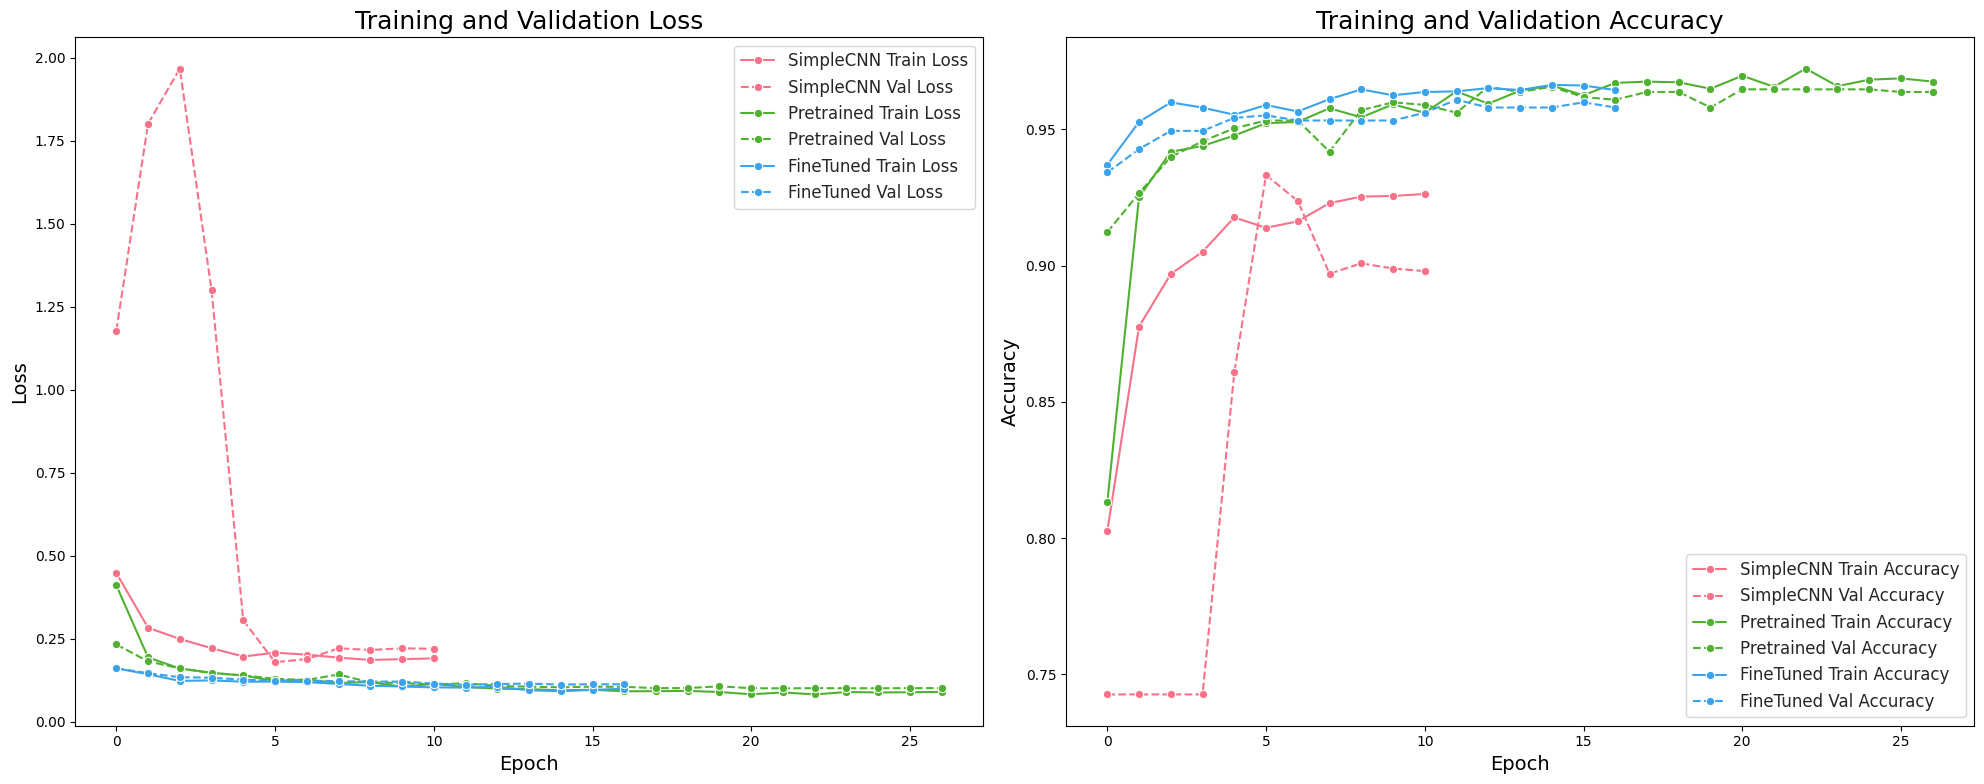

In [ ]:
# history_simplecnn, history_pretrained, and history_finetuned are defined and contain the training histories

# Creating a figure with two subplots: one for loss and one for accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Styling options
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 3)

# Plotting training and validation loss for all models on the first subplot (ax1)
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['loss'], label='SimpleCNN Train Loss', ax=ax1, color=palette[0], marker='o')
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['val_loss'], label='SimpleCNN Val Loss', ax=ax1, color=palette[0], linestyle='--', marker='o')
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['loss'], label='Pretrained Train Loss', ax=ax1, color=palette[1], marker='o')
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['val_loss'], label='Pretrained Val Loss', ax=ax1, color=palette[1], linestyle='--', marker='o')
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['loss'], label='FineTuned Train Loss', ax=ax1, color=palette[2], marker='o')
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['val_loss'], label='FineTuned Val Loss', ax=ax1, color=palette[2], linestyle='--', marker='o')
ax1.set_title('Training and Validation Loss', fontsize=18)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(loc='upper right', fontsize=12)

# Plotting training and validation accuracy for all models on the second subplot (ax2)
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['binary_accuracy'], label='SimpleCNN Train Accuracy', ax=ax2, color=palette[0], marker='o')
sns.lineplot(x=history_simplecnn.epoch, y=history_simplecnn.history['val_binary_accuracy'], label='SimpleCNN Val Accuracy', ax=ax2, color=palette[0], linestyle='--', marker='o')
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['binary_accuracy'], label='Pretrained Train Accuracy', ax=ax2, color=palette[1], marker='o')
sns.lineplot(x=history_pretrained.epoch, y=history_pretrained.history['val_binary_accuracy'], label='Pretrained Val Accuracy', ax=ax2, color=palette[1], linestyle='--', marker='o')
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['binary_accuracy'], label='FineTuned Train Accuracy', ax=ax2, color=palette[2], marker='o')
sns.lineplot(x=history_finetuned.epoch, y=history_finetuned.history['val_binary_accuracy'], label='FineTuned Val Accuracy', ax=ax2, color=palette[2], linestyle='--', marker='o')
ax2.set_title('Training and Validation Accuracy', fontsize=18)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(loc='lower right', fontsize=12)

# Displaying and saving the plots
plt.tight_layout()
plt.savefig("Comparison of losses and accuracies", dpi=400)
plt.show()


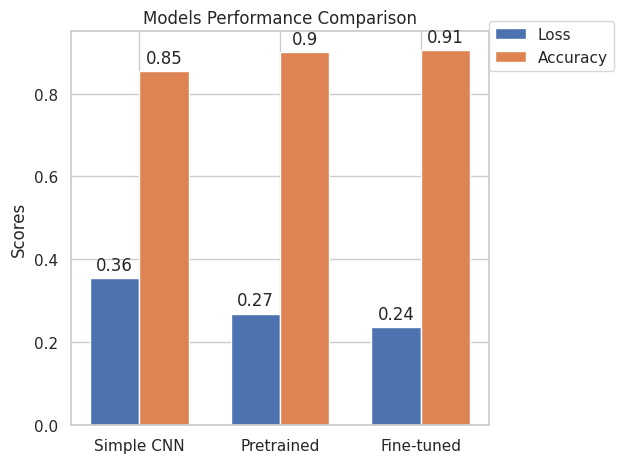

In [ ]:
# Scores - assuming each has [loss, accuracy]
scores = {
    'Simple CNN': score_simplecnn,
    'Pretrained': score_pretrained,
    'Fine-tuned': score_finetuned
}

# Preparing data for plotting
labels = list(scores.keys())
losses = [score[0] for score in scores.values()]
accuracies = [score[1] for score in scores.values()]

# Setting the positions and width for the bars
x = np.arange(len(labels))
width = 0.35

# Creating the bar plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, losses, width, label='Loss')
rects2 = ax.bar(x + width/2, accuracies, width, label='Accuracy')

# Adding labels, title and legend
ax.set_ylabel('Scores')
ax.set_title('Models Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=(1, 0.9))

# Function to add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding labels to the bars
autolabel(rects1)
autolabel(rects2)

# Displaying and saving the plot
plt.tight_layout()
plt.savefig("Model Performance Comparison", dpi=400)
plt.show()


Concluding this notebook, it's evident that the fine-tuning approach has yielded the best results. We will now showcase various performance metrics to comprehensively evaluate and understand the effectiveness of the fine-tuned model. These metrics are crucial for assessing the model's real-world applicability and reliability.

#<a href='#9'>Performance Metrics</a>

In [ ]:
# Creating a numerical label mapping for the classes
num_label = {'Normal': 0, 'Pneumonia': 1}

# Mapping the textual class labels in the test dataset to numerical labels
# This is important for evaluation metrics that require numerical instead of textual labels
Y_test = df_test['class'].copy().map(num_label).astype('int')


In [ ]:
# Resetting the test dataset generator before making predictions
# This ensures that the generator starts from the beginning, providing accurate alignment with the test labels
ds_test.reset()

# Generating predictions for the test dataset using the fine-tuned model
# 'predictions' will contain the output probabilities from the model
predictions = model_pretrained.predict(
    ds_test,  # Test data generator
    steps=len(ds_test),  # Number of steps equals the number of batches in the dataset
    verbose=0  # Silent mode (no output during the prediction)
)

# Converting the output probabilities into binary labels (0 or 1)
# A threshold of 0.5 is used: values above 0.5 are labeled as 1 (Pneumonia), else 0 (Normal)
pred_labels = np.where(predictions > 0.5, 1, 0)


In [ ]:
# Calculating and printing the accuracy score of the model on the test dataset
# 'accuracy_score' is a function from sklearn.metrics that compares the true labels with the predicted labels
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))


Test Accuracy:  0.905448717948718


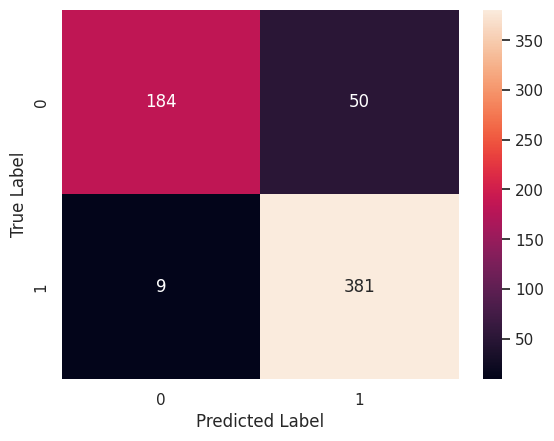

In [ ]:
# Computing the confusion matrix for the model's predictions on the test dataset
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)

# Using seaborn to create a heatmap visualization of the confusion matrix
sns.heatmap(
    confusion_matrix,  # The confusion matrix data
    annot=True,  # Annotate cells with numerical data
    fmt="d"  # Display integers in cells (digits format)
)

# Setting the label for the x-axis and its font size
plt.xlabel("Predicted Label", fontsize=12)

# Setting the label for the y-axis and its font size
plt.ylabel("True Label", fontsize=12)

# Displaying the heatmap plot
plt.savefig("Confusion_matrix", dpi=400)
plt.show()


In [ ]:
# Generating and printing a classification report for the model's predictions on the test dataset
# The classification report includes key metrics such as precision, recall, f1-score, and support for each class
print(metrics.classification_report(
    Y_test,  # True labels
    pred_labels,  # Predicted labels
    labels=[0, 1]  # The list of labels to include in the report (Normal: 0, Pneumonia: 1)
))


              precision    recall  f1-score   support

           0       0.95      0.79      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624



ROC_AUC:  0.9751588866973483


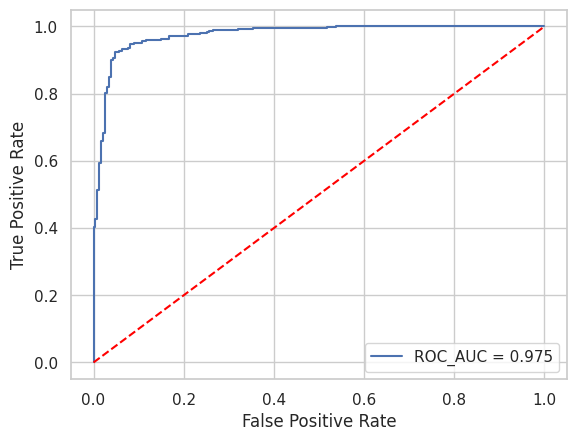

In [ ]:
# Calculating the ROC-AUC score for the model's predictions on the test dataset
# The ROC-AUC score is a performance measurement for classification problems at various threshold settings
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

# Calculating the False Positive Rate (FPR) and True Positive Rate (TPR) at various threshold levels
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

# Plotting the ROC curve
plt.plot(fpr, tpr, label='ROC_AUC = %0.3f' % roc_auc)

# Adding a middle dotted line (diagonal line representing random chance)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Setting the label for the x-axis and its font size
plt.xlabel("False Positive Rate", fontsize=12)

# Setting the label for the y-axis and its font size
plt.ylabel("True Positive Rate", fontsize=12)

# Adding a legend to the plot, positioned in the lower right area of the graph
plt.legend(loc="lower right")

# Displaying the ROC curve plot
plt.savefig("ROC_curve", dpi=400)
plt.show()


The high recall rate, nearing 100%, is particularly significant in the medical context, especially for diagnosing conditions like pneumonia where missing a positive case (false negative) can have serious consequences. Achieving this level of recall, which prioritizes minimizing false negatives, is crucial in healthcare applications. The fact that this performance is attained with a relatively small training dataset further underscores the model's effectiveness. Additionally, the strong performance is corroborated by the high ROC-AUC value, indicating the model's robustness in distinguishing between the 'Normal' and 'Pneumonia' classes. This balance of high recall and ROC-AUC highlights the model's potential utility in medical diagnostics, where accuracy and the minimization of false negatives are paramount.

#<a href='#10'>References</a>

- https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
- https://www.tensorflow.org/guide/keras/transfer_learning
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/applications/
- https://keras.io/api/applications/resnet/#resnet152v2-function